In [ ]:
#!pip install evaluate
!pip install jiwer > /dev/null

In [ ]:
import pandas as pd
import re
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
root_folder = "gdrive/MyDrive/emotion_recognition/"
data_path = root_folder + "data_init/"
data_seg_path = root_folder + "data_init_segments/"
res_folder = root_folder + 'experiments/'

In [ ]:
df_meta = pd.read_csv(res_folder + 'latest.csv')
# df_meta.columns

In [ ]:
import ast
df_meta['origin_text'] = df_meta['origin_text'].apply(ast.literal_eval)

# Data preparation

In [ ]:
!pip install langid > /dev/null
!pip install samplerate
!pip install resampy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for samplerate (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for samplerate
Failed to build samplerate
ERROR: Could not build wheels for samplerate, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.7 MB/s eta 0:00:00


In [ ]:
import re
import os
import langid

In [ ]:
def read_transcription(folder):
    for filename in os.listdir(folder + "/"):
        if not re.match(r".*\.txt", filename): continue

        with open(folder + "/" + filename) as file:
            return file.read().splitlines()

    return ""


def get_language(translation):
    text = ' .'.join(translation)
    return langid.classify(text)[0]


def get_audio_duration(transcript):
    line = transcript[-1]
    return re.sub(r".*\t([0-9.]+).*\t.*", "\\1", line)


def get_audio_file_name(folder):
    for filename in os.listdir(folder + "/"):
        if not re.match(r".*\.wav", filename): continue

        return filename

    return ""

def get_original_text(transcription):
    transcr_split = [re.split('\t|    ', line) for line in transcription]
    text = []
    i = 0
    for line in transcr_split:
        if len(line) == 4:
            text.append(line[3])
    return text

def get_emotion(info):
    split = info.split('_')

    if len(split) == 2:
        return 'lang_change'
    if len(split) != 3:
        return 'mixed'

    e = split[2]
    if e == 'n':
        return 'neutral'
    elif e == 's':
        return 'sad'
    elif e == 'a':
        return 'angry'
    elif e == 'd':
        return 'disgust'
    elif e == 'h':
        return 'happy'
    elif e =='p':
        return 'pleasant_surprise'
    else:
        return 'mixed'


def get_speaker(info):
    split = info.split('_')

    if len(split) == 1:
        return "b"

    return split[0]

In [ ]:
list_meta = []

files = [f for f in os.listdir(data_path)]
for f in files:
    if f.startswith('.'): continue

    dict_meta = {}
    # overall emotion - name of the folder
    emotion = re.sub(' ([a-zA-Z])', '_\\1', f)
    emotion = re.sub('[^a-zA-Z_]+', '', emotion)
    #print(f"{emotion=} {f=}")
    transcription = read_transcription(data_path + f)

    dict_meta['folder_name'] = f
    dict_meta['audio_file_name'] = get_audio_file_name(data_path + f)
    dict_meta['emotion'] = emotion
    dict_meta['speech_duration'] = get_audio_duration(transcription)
    dict_meta['language'] = get_language(transcription)
    dict_meta['origin_text'] = get_original_text(transcription)

    list_meta.append(dict_meta)

df_meta = pd.DataFrame(list_meta)
df_meta['speech_duration'] = df_meta['speech_duration'].astype(float)

In [ ]:
df_meta.loc[df_meta['emotion'] == 'lang_change', 'emotion'] = 'neutral'

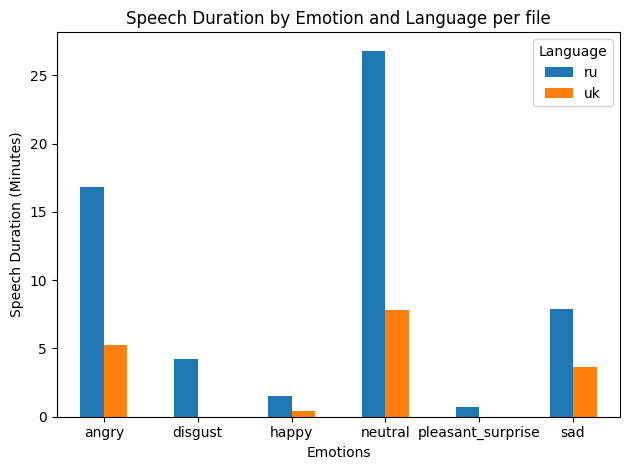

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))
bar_cont = df_meta.groupby(['emotion', 'language'])['speech_duration_min'].sum().unstack()
bar_cont.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.xlabel("Emotions")
plt.ylabel("Speech Duration (Minutes)")
plt.title("Speech Duration by Emotion and Language per file")
plt.legend(title="Language")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

In [ ]:
def change_lang(lang, langid_lang):
  if lang == 's':
    if langid_lang == 'ru':
      return 'ru'
    return 'uk'
  return lang


df_meta['emotion_split'] = df_meta['emotion']
df_meta.loc[df_meta['emotion_split'] == 'pleasant_surprise', 'emotion_split'] = 'happy'
df_meta.loc[df_meta['emotion_split'] == 'disgust', 'emotion_split'] = 'angry'
df_meta['emotion_split'] = df_meta['emotion_split'].apply(lambda x: 'no-conflict' if x in ['neutral', 'happy'] else 'conflit')
# df_meta['language'] = df_meta.apply(lambda row: change_lang(row['language'], row['langid_language']),
#                                   axis=1)
df_meta['emotion_split_lang'] = df_meta.apply(lambda row: row['emotion_split'] + '_' + row['language'], axis=1)
df_meta['speech_duration_min'] = df_meta['speech_duration'].astype(int) / 60

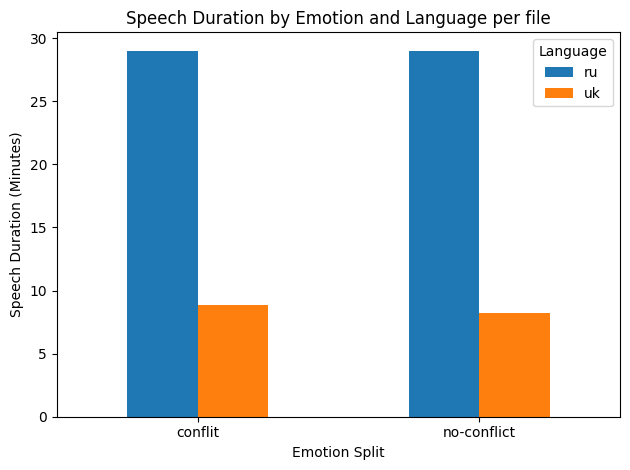

In [ ]:
bar_cont = df_meta.groupby(['emotion_split', 'language'])['speech_duration_min'].sum().unstack()
bar_cont.plot(kind='bar')
plt.xlabel("Emotion Split")
plt.ylabel("Speech Duration (Minutes)")
plt.title("Speech Duration by Emotion and Language per file")
plt.legend(title="Language")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

In [ ]:
def get_language(info):
    split = info.split('_')

    if len(split) == 2:
        return None
    if len(split) != 3:
        return None

    return split[1]

In [ ]:
import soundfile as sf
import librosa

def resample(file, file_out, sr_in=8000, sr_out=16000):
  y, sr = librosa.load(file, sr=sr_in)
  y_new = librosa.resample(y, orig_sr=sr, target_sr=sr_out)
  sf.write(file_out, y_new, sr_out, subtype='PCM_16')



In [ ]:
# split each line separately

list_meta_phrases = []
data_dir = 'data/'

for folder, emotion_context in zip(df_meta['folder_name'], df_meta['emotion']):
    transcr = [re.split('\t|    ', line) for line in read_transcription(data_path + folder)]
    i = 0
    for line in transcr:
        dict_meta = {}

        t1 = float(line[0])
        t2 = float(line[1])
        info = line[2]

        if len(line) == 4:
            phrase = line[3]
            lang = langid.classify(phrase)[0]
        else:
            phrase = ""
            lang = None

        emotion = get_emotion(info)
        speaker = get_speaker(info)

        if emotion in ['lang_change', 'mixed']:
            emotion = None
            i+=1
            continue

        dict_meta['folder_name'] = data_seg_path + emotion + '/'
        dict_meta['file_name'] = folder + '_' + info + '_' + str(i) + '.wav'
        dict_meta['res_file_name'] = "res_16_" + folder + '_' + info + '_' + str(i) + '.wav'
        dict_meta['conversation_folder_name'] = folder
        dict_meta['info'] = info
        dict_meta['emotion'] = emotion
        dict_meta['emotion_context'] = emotion_context
        dict_meta['speaker'] = speaker
        dict_meta['speech_duration'] = t2-t1
        dict_meta['language'] = get_language(info)
        dict_meta['langid_language'] = lang
        dict_meta['origin_text'] = phrase
        list_meta_phrases.append(dict_meta)
        i+=1

        #resample(dict_meta['folder_name']+dict_meta['file_name'], dict_meta['folder_name']+dict_meta['res_file_name'])

df_meta_phrases = pd.DataFrame(list_meta_phrases)
df_meta_phrases['speech_duration'] = df_meta_phrases['speech_duration'].astype(float)
df_meta_phrases

,folder_name,file_name,res_file_name,conversation_folder_name,info,emotion,emotion_context,speaker,speech_duration,language,langid_language,origin_text
0,gdrive/MyDrive/emotion_recognition/data_init_s...,neutral23щ98_s_r_n_0.wav,res_16_neutral23щ98_s_r_n_0.wav,neutral23щ98,s_r_n,neutral,neutral,s,8.426141,r,ru,да уточнил там эээ нужно будет да действительн...
1,gdrive/MyDrive/emotion_recognition/data_init_s...,neutral23щ98_c_r_n_2.wav,res_16_neutral23щ98_c_r_n_2.wav,neutral23щ98,c_r_n,neutral,neutral,c,1.504668,r,ru,здесь этого нет
2,gdrive/MyDrive/emotion_recognition/data_init_s...,neutral23щ98_c_u_n_4.wav,res_16_neutral23щ98_c_u_n_4.wav,neutral23щ98,c_u_n,neutral,neutral,c,2.257002,u,uk,операції послуг
3,gdrive/MyDrive/emotion_recognition/data_init_s...,neutral23щ98_c_r_n_5.wav,res_16_neutral23щ98_c_r_n_5.wav,neutral23щ98,c_r_n,neutral,neutral,c,0.900571,r,mn,тут есть эээ
4,gdrive/MyDrive/emotion_recognition/data_init_s...,neutral23щ98_c_u_n_6.wav,res_16_neutral23щ98_c_u_n_6.wav,neutral23щ98,c_u_n,neutral,neutral,c,1.375404,u,uk,перевстановіть сіп-пароль
...,...,...,...,...,...,...,...,...,...,...,...,...
541,gdrive/MyDrive/emotion_recognition/data_init_s...,neutral34567_c_r_n_14.wav,res_16_neutral34567_c_r_n_14.wav,neutral34567,c_r_n,neutral,neutral,c,11.572157,r,ru,Сереж давайте мне нужно принять решение мне ну...
542,gdrive/MyDrive/emotion_recognition/data_init_s...,neutral7_s_r_n_1.wav,res_16_neutral7_s_r_n_1.wav,neutral7,s_r_n,neutral,neutral,s,20.680950,r,ru,вы нам просто оплачиваете за автообзвон ии он ...
543,gdrive/MyDrive/emotion_recognition/data_init_s...,angry7865_c_r_a_0.wav,res_16_angry7865_c_r_a_0.wav,angry7865,c_r_a,angry,angry,c,20.277955,r,ru,Виктория мне надо чтобы вы меня больше не соед...
544,gdrive/MyDrive/emotion_recognition/data_init_s...,angry7865_s_r_n_1.wav,res_16_angry7865_s_r_n_1.wav,angry7865,s_r_n,neutral,angry,s,7.279266,r,ru,да смотрите если хотите я могу поставить задач...


In [ ]:
df_meta_phrases.to_csv(data_seg_path + 'seg_info.csv')

NameError: name 'df_meta_phrases' is not defined

In [ ]:
df_seg = pd.read_csv(data_seg_path + 'seg_info.csv')

def change_lang(lang, langid_lang):
  if lang == 's':
    if langid_lang == 'ru':
      return 'r'
    return 'u'
  return lang


df_seg = pd.read_csv(data_seg_path+'seg_info.csv').drop([48]).reset_index()
df_seg['emotion_split'] = df_seg['emotion']
df_seg.loc[df_seg['emotion_split'] == 'pleasant_surprise', 'emotion_split'] = 'happy'
df_seg.loc[df_seg['emotion_split'] == 'disgust', 'emotion_split'] = 'angry'
df_seg['emotion_split'] = df_seg['emotion_split'].apply(lambda x: 'no-conflict' if x in ['neutral', 'happy'] else 'conflit')
df_seg['language'] = df_seg.apply(lambda row: change_lang(row['language'], row['langid_language']),
                                  axis=1)
df_seg.loc[df_seg['language'] == 'u', 'language'] = 'uk'
df_seg.loc[df_seg['language'] == 'r', 'language'] = 'ru'
df_seg['emotion_split_lang'] = df_seg.apply(lambda row: row['emotion_split'] + '_' + row['language'], axis=1)
df_seg['speech_duration_min'] = df_seg['speech_duration'].astype(int) / 60

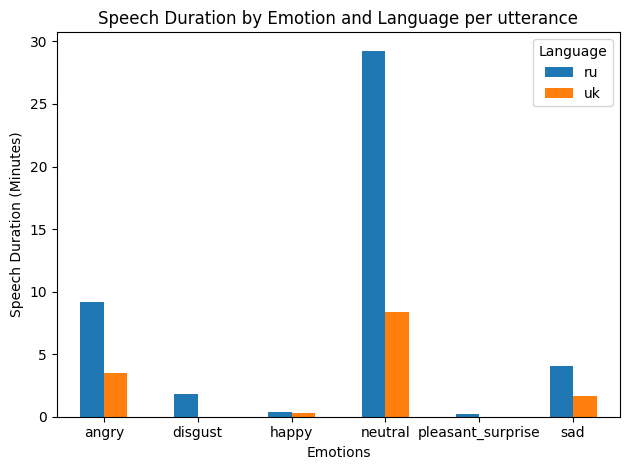

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))
bar_cont = df_seg.groupby(['emotion', 'language'])['speech_duration_min'].sum().unstack()
bar_cont.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.xlabel("Emotions")
plt.ylabel("Speech Duration (Minutes)")
plt.title("Speech Duration by Emotion and Language per utterance")
plt.legend(title="Language")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

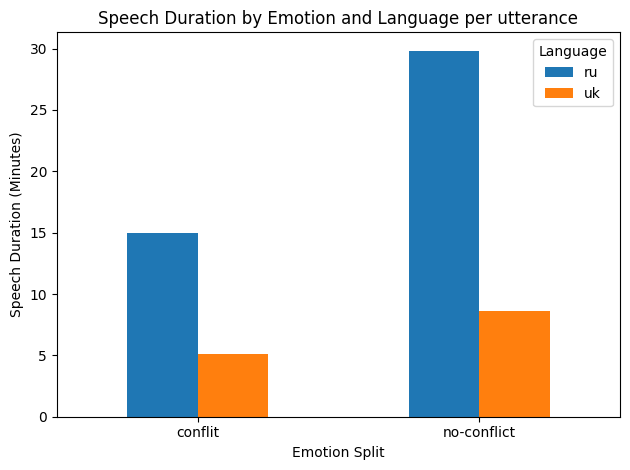

In [ ]:
bar_cont = df_seg.groupby(['emotion_split', 'language'])['speech_duration_min'].sum().unstack()
bar_cont.plot(kind='bar')
plt.xlabel("Emotion Split")
plt.ylabel("Speech Duration (Minutes)")
plt.title("Speech Duration by Emotion and Language per utterance")
plt.legend(title="Language")
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

In [ ]:
!ls gdrive/MyDrive/emotion_recognition/data_init_segments/disgust

disgust23498_c_r_d_0.wav  disgust23498_c_r_d_4.wav  disgust_c_r_d_0.wav  res_16_disgust_c_r_d_0.wav
disgust23498_c_r_d_1.wav  disgust37256_c_r_d_2.wav  disgust_с_r_d_2.wav


In [ ]:
!ls gdrive/MyDrive/emotion_recognition/data_init_segments/neutral

 angry0987654_s_u_n_1.wav      neutral23щ98_c_s_n_13.wav    neutral754_c_r_n_0.wav
 angry0987654_s_u_n_3.wav      neutral23щ98_c_u_n_14.wav    neutral754_c_r_n_3.wav
 angry12345_s_u_n_0.wav        neutral23щ98_c_u_n_4.wav     neutral754_s_r_n_2.wav
 angry12345_s_u_n_2.wav        neutral23щ98_c_u_n_6.wav     neutral76543_c_r_n_10.wav
 angry2_s_r_n_3.wav	       neutral23щ98_s_r_n_0.wav     neutral76543_c_r_n_12.wav
 angry2_s_r_n_6.wav	       neutral23щ98_s_r_n_9.wav     neutral76543_c_r_n_1.wav
 angry324565_s_u_n_1.wav       neutral23щ98_s_s_n_12.wav    neutral76543_c_r_n_3.wav
 angry324565_s_u_n_3.wav       neutral2_c_r_n_0.wav	    neutral76543_c_r_n_5.wav
 angry345543_s_r_n_10.wav      neutral2_c_r_n_1.wav	    neutral76543_s_r_n_0.wav
 angry345543_s_r_n_13.wav      neutral2_c_r_n_3.wav	    neutral76543_s_r_n_13.wav
 angry345543_s_r_n_1.wav       neutral2_c_r_n_5.wav	    neutral76543_s_r_n_6.wav
 angry345543_s_r_n_3.wav       neutral2_c_r_n_7.wav	    neutral76543_s_r_n_7.wav
 angry34554

In [ ]:
from IPython.display import Audio, display

i=0
test_audio_path = os.path.join(data_path, df_meta['folder_name'].values[i], df_meta['audio_file_name'].values[i])
print(test_audio_path)
display(Audio(test_audio_path, autoplay=True))

gdrive/MyDrive/emotion_recognition/NLP project/sad3/1630402692.3297299_1130dcef70a0b70bc5b9516008b31aa6 (1).wav


# ASR models

In [ ]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import AutoModelForCTC, Wav2Vec2BertProcessor
from transformers import pipeline
import librosa

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

print(device, torch_dtype)
#TODO: W&B

cpu torch.float32


In [ ]:
# utils
def read_audio(fname):
  sr = 16000
  speech, _ = librosa.load(fname, sr=sr, mono=True)
  return speech

In [ ]:
# "openai/whisper-{tiny}"
class Wav2Vec2BERTHuggingFace:
  def __init__(self, name):
    self.name = name
    self.processor = None
    self.model = None
    #self.forced_decoder_ids = None

  def init(self):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    self.model = AutoModelForCTC.from_pretrained(self.name).to(device)
    self.processor = Wav2Vec2BertProcessor.from_pretrained(self.name)

  def process_audio(self, audio_fname, lang=None, task="transcribe"):
    #task = transcribe/translate
    speech = read_audio(audio_fname)

    if speech is None:
      print(f'speech == None for {audio_fname}')
      return ""

    input_features = self.processor(speech, sampling_rate=16000).input_features
    features = torch.tensor(input_features).to(device)

    with torch.no_grad():
      logits = self.model(features).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    predictions = self.processor.batch_decode(predicted_ids)

    return predictions

In [ ]:
class ASRPipelineHuggingFace:
  def __init__(self, name):
    self.name = name
    self.pipe = None

  def init(self):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    self.pipe = pipeline(
      "automatic-speech-recognition",
      model=self.name,
      device=device
    )

  def process_audio(self, audio_fname, lang=None, task="transcribe", chunk_lenght=30, stride=None):
    #task = transcribe/translate
    speech = read_audio(audio_fname)

    if speech is None:
      print(f'speech == None for {audio_fname}')
      return ""

    if stride is None:
      stride = chunk_lenght / 6  # default value https://github.com/huggingface/transformers/blob/5cd16f01db3b5499d4665e8624801ed30ba87bdd/src/transformers/pipelines/automatic_speech_recognition.py

    output = self.pipe(speech,
                        return_timestamps=True,
                        chunk_length_s=chunk_lenght,
                        stride_length_s=stride,  #or set list [left, right]
                        #batch_size=32,
                        # note "arampacha/whisper-large-uk-2", does not support task parameter. need to pass it using old ways
                        generate_kwargs={"language": lang, "task" : task}
                       )

    return output["text"]

# Evaluation metrics

In [ ]:
import jiwer
import jiwer.transforms as tr

wer_standardize = tr.Compose(
    [
        tr.ToLowerCase(),
        tr.RemoveKaldiNonWords(),
        tr.RemoveWhiteSpace(replace_by_space=True),
        tr.RemoveMultipleSpaces(),
        tr.RemovePunctuation(),
        tr.Strip(),
        tr.ReduceToListOfListOfWords(),
    ]
)

In [ ]:
def calc_word_error(reference_text, generated_text):
   return jiwer.process_words(
      generated_text,
      reference_text,
      reference_transform=wer_standardize,
      hypothesis_transform=wer_standardize,
  )

# Evaluation pipeline

In [ ]:
!pip install wandb
!pip install kenlm
!pip install pyctcdecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.4/427.4 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import time
import wandb
from tqdm.auto import tqdm

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
res_folder = root_folder + 'experiments/'

In [ ]:
def gen_and_eval(model, df_index, lang=None, task="transcribe"):
  audio_path = os.path.join(data_path, df_meta['folder_name'].values[df_index], df_meta['audio_file_name'].values[df_index])
  gen_transcript = model.process_audio(audio_path, lang=lang, task=task)
  gt = ". ".join(df_meta['origin_text'].values[df_index])
  return calc_word_error(gen_transcript, gt)

In [ ]:
# setup W&B

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32


config = {
    "model_name" : "",
    "fine-tuned" : False,
    "framework" : "HF pipeline",
    "data" : "init_full_1h",
    "lang" : "auto",
    "task" : "transcribe",
    "chunk_length_s" : 30,
    "stride_length_s" : 30/6,
    "batch_size" : "default",
    "device" : device,
    "torch_dtype" : torch_dtype,
    "LM" : None,
    "chunking" : "HF pipeline (stride)"
}

In [ ]:
wandb.finish()

In [ ]:
model_names = [
          # "openai/whisper-tiny",
          # "openai/whisper-base",
          # "openai/whisper-small", # ----> 244M
           "openai/whisper-medium", # ---> 769M
          # "openai/whisper-large",
           "openai/whisper-large-v2",
           "openai/whisper-large-v3",
          #"Yehor/wav2vec2-xls-r-300m-uk-with-small-lm" # ---> with kenlm and pyctcdecode
          #"arampacha/whisper-large-uk-2",
          #"robinhad/wav2vec2-xls-r-300m-uk", # ---> no lm
          #"Yehor/w2v-bert-2.0-uk", # ---> 600M
          #"Yehor/wav2vec2-xls-r-1b-uk-with-lm",
          #"arampacha/wav2vec2-xls-r-1b-uk",
          #"voidful/wav2vec2-xlsr-multilingual-56",
          #"facebook/wav2vec2-base-960h" ---> only english
          #"nvidia/stt_uk_citrinet_1024_gamma_0_25", # ----> not working with pipeline
          # "facebook/seamless-m4t-v2-large", # -> 2.4B, need to specify 'tgt_lang'. 'chung_length_s' is experimental
          # "facebook/mms-1b-all",
          #"guillaumekln/faster-whisper-large-v2" --> not working with pipeline
          ]

task = "translate"

for name in tqdm(model_names):
  print(f"processing {name}")

  timestr = time.strftime("%m%d-%H%M")
  config["model_name"] = name
  run = wandb.init(project="emotion_recognition",
             name=f"e_{timestr}_basic_eval",
             config=config)

  #model = ASRPipelineHuggingFace(name)
  model = Wav2Vec2BERTHuggingFace(name)
  model.init()

  col_transc = name + "_transc"
  col_wer = name + "_wer"
  df_meta[col_transc] = ""
  df_meta[col_wer] = 0

  for df_index, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    res = gen_and_eval(model, df_index, task=task)
    row[col_transc] = " ".join(res.hypotheses[0])
    row[col_wer] = round(res.wer, 2)
    run.log({"idx" : df_index,
              "lang" : row["language"],
              "duration" : row["speech_duration"],
              "wer" : res.wer,
              "mer" : res.mer,
              "wil" : res.wil,
              "wip" : res.wip})

    df_meta.iloc[df_index] = row

  res_filename = res_folder + "res-" + name.split('/')[1] + '-' + timestr + ".csv"
  df_meta.to_csv(res_filename)
  df_meta.to_csv(res_folder + 'latest.csv')

  run.log({"wer_avg" : df_meta[col_wer].mean()})
  wandb.finish()


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: Currently logged in as: patenko-pn (lp-ucu). Use `wandb login --relogin` to force relogin


processing Yehor/w2v-bert-2.0-uk


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/90 [00:00<?, ?it/s]

duration,▄▃▅▂▃▅▄▄▄▄▁▆▁▃▃▅▂▅▃▁▃▁▂▅▆▃▄▂▁▂▅▃█▂▅▄▂▃▄▄
idx,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
mer,▆▅▆▂▆▆▁▆▆▆█▆▃▆▄▆▇▆▆▅▇▃▆▂▆▆▇▆▆▅▆▆▇▆▁▁▆▆▅▅
wer,▅▄▅▂▆▇▂▅▅▅█▄▃▅▃▅▅▇▅▅▆▃▅▁▅▅▅▅▅▄▅▅▇▇▁▁▅▅▄▄
wer_avg,▁
wil,█▇█▂▇▇▁██▇█▇▅▇▆██▇█▇█▅█▃▇███▇▇▇▇█▇▁▁▇▇▆▆
wip,▁▂▁▇▂▂█▁▁▂▁▂▄▂▃▁▁▂▁▂▁▄▁▆▂▁▁▁▂▂▂▂▁▂██▂▂▃▃
duration,51.99475
idx,89
lang,ru
mer,0.74138


In [ ]:
columns = list(df_meta.filter(regex="wer").columns.values) + ['language']

In [ ]:
df_meta_summary = df_meta[columns].groupby(by=['language']).mean().transpose()
df_meta_summary = df_meta_summary.sort_values(by=['uk', 'ru'])
df_meta_summary

language,ru,uk
openai/whisper-large-v2_wer,0.400143,0.3880
openai/whisper-large-v3_wer,0.379714,0.4150
arampacha/wav2vec2-xls-r-1b-uk_wer,0.886714,0.4240
Yehor/w2v-bert-2.0-uk_wer,0.916857,0.5075
openai/whisper-large_wer,0.425286,0.5190
Yehor/wav2vec2-xls-r-1b-uk-with-lm_wer,0.909571,0.5350
Yehor/wav2vec2-xls-r-300m-uk-with-small-lm_wer,0.923286,0.5795
robinhad/wav2vec2-xls-r-300m-uk_wer,0.915000,0.5835
openai/whisper-small_wer,0.512286,0.6970
arampacha/whisper-large-uk-2_wer,0.896286,0.7135
